<h5>AnyLogistics Tutorial</h5>

In this notebook we model a scenario using SupplyNetPy that is available in AnyLogistix tutorials, and try to generate similar performance stats.
The AnyLogistix simulation scenario tutorial can be found [here](https://anylogistix.help/tutorial/tutorial-simulation-main.html).

We have further simplified the system be including only one supplier, three distribution centers, and four retailers.

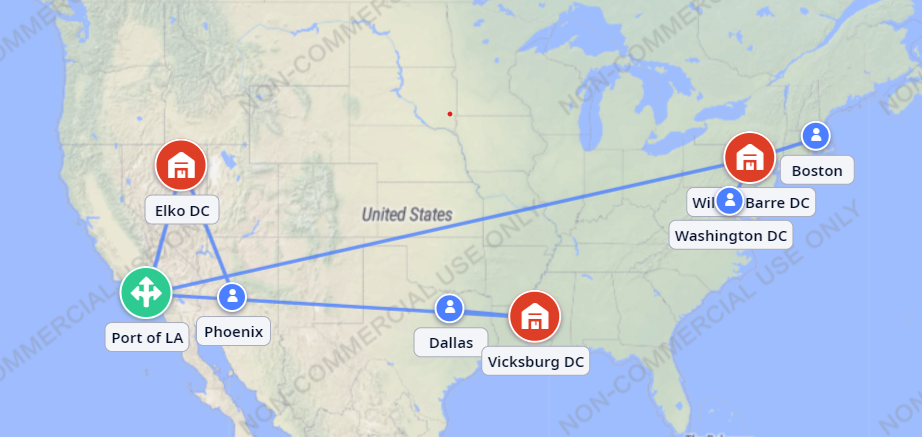

We will create a similar model with same configuration (parameter values) to generate same stats.

In [ ]:
import SupplyNetPy.Components as scm

import simpy
import numpy as np
import random
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'core'